In [ ]:
import os
import re
import time
import json

from langchain_core.documents import Document 
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import Chroma
from typing import List
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from pydantic import Field, BaseModel
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Optional
from langsmith import traceable
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(model_name="llama-3.3-70b-versatile")

In [56]:
current_dir = os.getcwd()
file_path = os.path.join(current_dir, "docs", "civil_law_clean.txt")
persistent_directory = os.path.join(current_dir, "db", "chroma_db")

# Ensure the text file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist. Please check the path.")

# Initialize embeddings (always)
embeddings = HuggingFaceEmbeddings(
    model_name="sayed0am/arabic-english-bge-m3"
)

# Initialize vector store, whether it exists or not
db = Chroma(
    embedding_function=embeddings,
    persist_directory=persistent_directory
)

# Only add documents if the directory is new (or if you want to reprocess)
if not os.path.exists(persistent_directory):
    print("Persistent directory does not exist. Initializing vector store...")

    loader = TextLoader(file_path)
    document = loader.load()

    raw_text = document[0].page_content
    docs = split_egyptian_civil_law(raw_text)

    batch_size = 50
    for i in range(0, len(docs), batch_size):
        batch = docs[i:i + batch_size]
        db.add_documents(batch)
        print(f"Processed {i + len(batch)} / {len(docs)} documents")

    db.persist()
    print("Vector store created and persisted.")

else:
    print("Persistent directory exists. Loaded existing vector store.")

Persistent directory exists. Loaded existing vector store.


In [57]:
def retrieve_articles(query: str, k: int = 4):
    """
    Retrieves the most relevant legal articles from the Egyptian Civil Law.
    Returns LangChain Documents with full hierarchy metadata.
    """
    docs = db.similarity_search(
        query,
        k=k,
        filter={"type": "article"}
    )
    return docs

In [58]:
def print_retrieved_articles(docs):
    for i, doc in enumerate(docs, 1):
        meta = doc.metadata
        print("=" * 80)
        print(f"[{i}] {meta.get('title')}")
        print(f"📘 Book: {meta.get('book')}")
        print(f"📂 Part: {meta.get('part')}")
        print(f"📄 Chapter: {meta.get('chapter')}")
        print("-" * 80)
        print(doc.page_content)  # preview only

In [59]:
query = "إذا تعارضت المادة 147 والمادة 150 في موضوع العقد، كيف يتم حل النزاع؟"
answer = retrieve_articles(query, k=5)
print_retrieved_articles(answer)

[1] المادة 147
📘 Book: الكتاب الأول – الالتزامات بوجه عام
📂 Part: الباب الأول – مصادر الالتزام
📄 Chapter: الفصل الأول – العقد
--------------------------------------------------------------------------------
المادة 147

147
العقد شريعة المتعاقدين، فلا يجوز نقضه أو تعديله إلا باتفاق الطرفين أو لأسباب يقررها القانون.

إذا طرأت حوادث استثنائية لم يكن في الوسع توقعها، وترتب على حدوثها أن تنفيذ الالتزام صار مرهقًا للمدين، جاز للقاضي بعد الموازنة بين مصالح الطرفين أن يرد الالتزام إلى الحد المعقول. ويكون أي اتفاق على خلاف ذلك باطلاً.
[2] المادة 149
📘 Book: الكتاب الأول – الالتزامات بوجه عام
📂 Part: الباب الأول – مصادر الالتزام
📄 Chapter: الفصل الأول – العقد
--------------------------------------------------------------------------------
المادة 149

149
– إذا تم العقد بطريق الإذعان واشتمل على شروط تعسفية، جاز للقاضي تعديلها أو إعفاء الطرف المذعن منها وفق العدالة، ويقع باطلاً كل اتفاق على خلاف ذلك.
[3] المادة 157
📘 Book: الكتاب الأول – الالتزامات بوجه عام
📂 Part: الباب الأول – مصادر الالتزام
📄 C

In [60]:
query = "ما هي مسؤولية البائع إذا كان المبيع به عيب خفي ولم يذكر في العقد؟"
answer = retrieve_articles(query, k=5)
print_retrieved_articles(answer)

[1] المادة 447
📘 Book: الكتاب الثاني – العقود المسماة
📂 Part: الباب الأول – العقود التي تقع على الملكية
📄 Chapter: الفصل الأول – البيع
--------------------------------------------------------------------------------
المادة 447

447
يضمن البائع العيوب التي تنقص القيمة أو المنفعة ولو لم يعلم بها.

ولا يضمن العيوب الظاهرة أو التي يمكن كشفها إلا إذا أكد خلو المبيع منها أو تعمد إخفاءها.
[2] المادة 449
📘 Book: الكتاب الثاني – العقود المسماة
📂 Part: الباب الأول – العقود التي تقع على الملكية
📄 Chapter: الفصل الأول – البيع
--------------------------------------------------------------------------------
المادة 449

449
يجب على المشتري فحص المبيع وإخطار البائع بالعيب خلال مدة معقولة.

وإذا كان العيب خفيًا، وجب الإخطار فور ظهوره.
[3] المادة 448
📘 Book: الكتاب الثاني – العقود المسماة
📂 Part: الباب الأول – العقود التي تقع على الملكية
📄 Chapter: الفصل الأول – البيع
--------------------------------------------------------------------------------
المادة 448

448
لا يضمن البائع العيب الذي جرى العرف على 

In [61]:
query = "ما هو نص المادة بين 80 و 90 التي تتكلم عن الالتزام؟"
answer = retrieve_articles(query, k=5)
print_retrieved_articles(answer)

[1] المادة 787
📘 Book: الكتاب الثاني – العقود المسماة
📂 Part: الباب الخامس - الكفالة
📄 Chapter: الفصل الثاني - آثار الكفالة
--------------------------------------------------------------------------------
المادة 787

787
يلتزم الدائن بتسليم الكفيل المستندات اللازمة لممارسة حقه في الرجوع عند الوفاء.

إذا كان الدين مضمونًا بمنقول مرهون أو محبوس، يجب على الدائن التخلي عنه للكفيل.

إذا كان مضمونًا بتأمين عقاري، يلتزم الدائن بنقل التأمين على الكفيل مع تحمل المصروفات على أن يرجع بها على المدين.
[2] المادة 347
📘 Book: الكتاب الأول – الالتزامات بوجه عام
📂 Part: الباب الثاني - آثار الالتزام
📄 Chapter: الفصل الأول - الوفاء
--------------------------------------------------------------------------------
المادة 347

347
إذا كان محل الالتزام شيئًا معينًا بالذات، وجب تسليمه في المكان الذي كان موجودًا فيه وقت نشوء الالتزام، ما لم يوجد اتفاق أو نص يقضي بغير ذلك.

أما في الالتزامات الأخرى، فيكون الوفاء في المكان الذي يوجد فيه موطن المدين وقت الوفاء، أو في المكان الذي يوجد فيه مركز أعمال المدين إذا كان 

In [62]:
#######################################
#######For The Preprocessor Node#######
#######################################
PREPROCESSOR_PROMPT = """
أنت مساعد قانوني متخصص في القانون المدني المصري.

المطلوب:
1. أعد صياغة السؤال بصيغة قانونية واضحة ودقيقة.
2. حول أي أرقام مكتوبة بالكلمات إلى أرقام رقمية. على سبيل المثال: "تسعون" → "90" إن وجد.
3. حول أي فواصل أو مدى في المواد إلى صيغة رقمية مباشرة. مثال: "بين ثمانين وتسعين" → "بين 80 و 90" إن وجد.
4. صنّف السؤال إلى أحد الأنواع التالية فقط:
   - تحليلي (يحتاج شرح أو تفسير)
   - نصّي (يطلب نص مادة أو حكم حرفي)
   - خارج السياق (ليس سؤالًا قانونيًا مناسبًا)

قواعد صارمة:
- لا تضف سياقًا قانونيًا غير موجود في السؤال الأصلي.
- إذا كان السؤال خارج السياق القانوني، لا تحاول "قوننته".
- لا تغيّر نطاق السؤال أو موضوعه.

أعد النتيجة بصيغة JSON فقط بهذا الشكل:

{{
  "rewritten_question": "...",
  "classification": "تحليلي | نصّي | خارج السياق"
}}

السؤال:
{question}
"""

#######################################
##########For The Refine Node##########
#######################################
UNIFIED_REFINE_PROMPT = """
أنت خبير قانوني في القانون المدني المصري.

السؤال:
{query}

{reason_block}

المطلوب:
1. أعد صياغة السؤال بصيغة قانونية أدق وأكثر تحديدًا.
2. حدّد الموضوع القانوني محل السؤال بوضوح (مثل: الإيجار، البطلان، المسؤولية، الالتزام).
3. لا تغيّر المعنى الأصلي للسؤال ولا توسّع نطاقه.
4. إذا كان سبب الفشل مذكورًا، فاستعمله لتحسين الصياغة فقط دون اختراع وقائع.

تنبيهات مهمة:
- لا تُعيد refined_query = null إلا إذا كان السؤال:
  أ) لا يحتوي على موضوع قانوني مدني يمكن تحديده
  ب) أو يستحيل ربطه بأي حكم قانوني دون وقائع جوهرية مفقودة
- إذا كان السؤال عامًا، حاول تضييقه قدر الإمكان مع الإبقاء على قابليته للإجابة.
- لا تضف أي معلومات أو افتراضات غير موجودة في السؤال.

أعد النتيجة بصيغة JSON فقط:

{{
  "refined_query": "..."
}}

إذا تعذّر تحسين السؤال قانونيًا رغم المحاولة:
{
  "refined_query": null
}
"""


#######################################
########For The LLM Grader Node########
#######################################
LLM_GRADER_PROMPT = """
أنت مقيّم قانوني خبير في القانون المدني المصري.

السؤال:
{query}

المستندات المسترجعة:
{docs}

المطلوب:
قيّم ما إذا كانت هذه المستندات تصلح للإجابة القانونية على السؤال.

معايير التقييم:
1. إذا كانت المستندات غير مرتبطة مباشرة بموضوع السؤال → pass = false
2. إذا كانت المستندات عامة جدًا أو لا تنظم المسألة محل السؤال → pass = false
3. إذا احتوت المستندات على:
   - مادة قانونية تنظم المسألة مباشرة
   - أو قاعدة عامة منضبطة مستخلصة مباشرة من النص
   → pass = true

قواعد صارمة:
- إذا كانت المستندات لا تنتمي للقانون المدني المصري → pass = false
- لا يُقبل الاستنتاج البعيد أو القياس غير المنضبط
- لا يُعتبر الفهم الفقهي أو الرأي العام كافيًا دون نص
- يُقبل الحكم إذا كانت النصوص تشكل قاعدة عامة مستقرة تنطبق على نوع الواقعة محل السؤال

عند الفشل:
- اذكر السبب بدقة (نقص نص، خطأ موضوعي، غموض، عدم تنظيم المسألة)

أعد النتيجة بصيغة JSON فقط:

{{
  "pass": true/false,
  "reason": "..."
}}
"""


#######################################
#########For The Generate Node#########
#######################################
ANALYTICAL_PROMPT = """
أنت مساعد قانوني متخصص في القانون المدني المصري.

المواد القانونية المستخرجة:
{context_text}

السؤال:
{query}

المطلوب:
أجب بصيغة قانونية تحليلية مقيّدة بالنصوص فقط، مع توضيح:
- القاعدة القانونية المستخلصة من المواد
- نطاق تطبيق هذه القاعدة كما ورد في النص
- مدى انطباقها على السؤال في حدود الوقائع المذكورة فقط

قواعد حاكمة:
- لا تُنشئ أو تفترض وقائع غير مذكورة صراحة في السؤال.
- لا تستنتج نتائج قانونية إلا إذا كانت:
  أ) واردة صراحة في النص
  ب) أو مستخلصة مباشرة كقاعدة عامة منضبطة
- يمنع منعًا باتًا الاستشهاد بأي مادة غير موجودة في السياق.
- لا تكرر النص حرفيًا إلا عند الضرورة.
- استخدم فقط المواد الضرورية للإجابة ولا تستعرض جميع المواد المسترجعة إن لم تكن لازمة مباشرة.

الاستشهاد:
- يجب إرفاق كل قاعدة أو حكم قانوني باستشهاد واضح:
  (المادة 123 مدني)

في الحالات الآتية امتنع عن الإجابة:
- إذا كانت المواد غير مرتبطة مباشرة بالسؤال.
- إذا لم يوجد نص أو قاعدة قانونية تحكم المسألة
- إذا كان السؤال يتطلب وقائع غير متاحة

عند التعذر:
اذكر سبب التعذر بوضوح (غياب النص، نقص الوقائع، خروج عن نطاق القانون المدني).
ولا تقدّم أي تحليل قانوني بديل.
"""

In [63]:
class State(TypedDict):
    # Previous fields
    last_query: Optional[str]
    last_results: List[Document]
    last_answer: Optional[str]

    current_book: Optional[str]
    current_part: Optional[str]
    current_chapter: Optional[str]
    current_article: Optional[int]

    filter_type: str
    k: int
    books_in_scope: List[str]

    query_history: List[str]
    retrieval_history: List[List[Document]]
    answer_history: List[str]

    db_initialized: bool
    db: Optional[Chroma]
    split_config: dict

    # Preprocessor outputs
    rewritten_question: Optional[str]
    classification: Optional[str]  # analytical | textual | off_topic

    # Retriever outputs
    retrieval_confidence: Optional[float]
    retry_count: int
    max_retries: int 

    # Refinement / grading
    refined_query: Optional[str]
    grade: Optional[str]  # pass | refine | fail
    llm_pass: Optional[bool]
    failure_reason: Optional[str]
    proceedToGenerate: Optional[bool]
    retrieval_attempts: int
    final_answer: str | None

# Preprocessor Node

In [64]:
def fast_filters(query: str) -> str | None:
    """
    Applies fast, rule-based filters to the query.
    """
    query = query.strip()

    if len(query) < 5:
        return "off_topic"

    if not re.search(r"[\u0600-\u06FF]", query):  # Arabic check
        return "off_topic"

    return None

@traceable(name="Preprocessor Node")
def preprocessor_node(state: State) -> State:
    """
    Preprocesses the user's query by rewriting and classifying it.
    """
    query = state.get("last_query", "")
    if not query:
        state["classification"] = "off_topic"
        state["rewritten_question"] = None
        return state

    # 1. Rule-based filters
    fast_result = fast_filters(query)
    if fast_result == "off_topic":
        state["rewritten_question"] = None
        state["classification"] = "off_topic"
        return state

    # 2. LLM call
    prompt = PREPROCESSOR_PROMPT.format(question=query)
    response = llm.invoke(prompt)
    content = response.content.strip()

    # 3. Parse JSON
    try:
        data = json.loads(content)
    except json.JSONDecodeError:
        state["rewritten_question"] = query
        state["classification"] = "off_topic"
        return state

    # 4. Normalize labels
    classification_map = {
        "تحليلي": "analytical",
        "نصّي": "textual",
        "خارج السياق": "off_topic"
    }

    state["rewritten_question"] = data.get("rewritten_question", query)
    state["classification"] = classification_map.get(
        data.get("classification"),
        "off_topic"
    )

    # 5. Update history
    state["query_history"].append(query)

    return state

In [65]:
@traceable(name="Off-Topic Node")
def off_topic_node(state: State) -> State:
    state["final_answer"] = (
        "يبدو أن السؤال المطروح خارج نطاق اختصاص هذا النظام. "
        "يرجى طرح سؤال متعلق بالقانون المدني أو الأحكام القانونية ذات الصلة."
    )
    return state

# Textual

In [66]:
@traceable(name="Textual Node")
def textual_node(state: dict) -> dict:
    """
    Handles textual/legal questions that can be answered by
    directly retrieving the relevant civil law articles.

    Assumes the preprocessor has normalized:
    - Numbers in words → digits
    - Intervals like 'بين X و Y' → digits
    """
    db = state["db"]
    query = state.get("rewritten_question") or state["last_query"]

    # Check for interval query: "بين X و Y"
    range_match = re.search(r"بين\s*(\d+)\s*و\s*(\d+)", query)
    if range_match:
        start, end = int(range_match.group(1)), int(range_match.group(2))
        docs: List[Document] = []
        for num in range(start, end + 1):
            docs += db.similarity_search(
                f"المادة {num}",
                k=1,
                filter={
                    "$and": [
                        {"type": {"$eq": "article"}},
                        {"index": {"$eq": num}}
                    ]
                }
            )
        state["current_article"] = f"{start}-{end}"
        state["last_results"] = docs
        state["final_answer"] = "\n\n".join([doc.page_content for doc in docs]) if docs else \
            "عذرًا، لم أتمكن من العثور على نص المواد المطلوبة."
        return state

    # Check for exact article number
    article_match = re.search(r"المادة\s*(\d+)", query)
    if article_match:
        article_num = int(article_match.group(1))
        state["current_article"] = article_num
        docs: List[Document] = db.similarity_search(
            f"المادة {article_num}",
            k=1,
            filter={
                "$and": [
                    {"type": {"$eq": "article"}},
                    {"index": {"$eq": article_num}}
                ]
            }
        )
        state["last_results"] = docs
        state["final_answer"] = "\n\n".join([doc.page_content for doc in docs]) if docs else \
            "عذرًا، لم أتمكن من العثور على نص المادة المطلوب."
        return state

    # Fallback: semantic search (no number or vague query)
    docs: List[Document] = db.similarity_search(
        query,
        k=3,
        filter={"type": {"$eq": "article"}}
    )
    state["last_results"] = docs
    state["final_answer"] = "\n\n".join([doc.page_content for doc in docs]) if docs else \
        "عذرًا، لم أتمكن من العثور على نص المادة المطلوب."

    return state


# Analytical

In [67]:
# def analytical_node(state: dict, db, llm, k: int = 5, similarity_threshold: float = 0.35) -> dict:
#     """
#     Handles analytical questions (needs reasoning, explanation, or interpretation)
#     based on the Egyptian Civil Law corpus.

#     Inputs:
#         - state: current RAG state
#         - db: Chroma vector store
#         - llm: language model instance
#         - k: number of articles to retrieve
#         - similarity_threshold: min similarity to keep a document
#     """
#     query = state.get("rewritten_question") or state["last_query"]

#     # 1️⃣ Retrieve top-k relevant articles (semantic search)
#     retrieved_docs = db.similarity_search(query, k=k, filter={"type": "article"})

#     # Optional: filter by similarity if the library supports returning scores
#     # For now, assume retrieved_docs is relevant

#     if not retrieved_docs:
#         state["final_answer"] = "عذرًا، لم أتمكن من العثور على مواد قانونية مناسبة لشرح هذا السؤال."
#         state["last_results"] = []
#         return state

#     state["last_results"] = retrieved_docs

#     # 2️⃣ Construct LLM prompt
#     # Include context (articles) + question + instruction
#     context_text = "\n\n".join([f"{doc.metadata.get('title')}: {doc.page_content}" for doc in retrieved_docs])

#     # 3️⃣ LLM call

#     prompt = ANALYTICAL_PROMPT.format(
#         context_text=context_text,
#         query=query
#     )
#     response = llm.invoke(prompt)
#     answer = response.content.strip()

#     state["final_answer"] = answer
#     return state

# Retrive

In [68]:
@traceable(name="Retriever Node")
def retrieve_node(state: dict, k: int = 5) -> dict:
    """
    Retrieve relevant articles from the Egyptian Civil Law corpus
    based on the rewritten question. Stores results in state for grading.

    Inputs:
        - state: current RAG state
        - db: Chroma vector store
        - k: number of articles to retrieve
    """
    db = state["db"]
    query = state.get("rewritten_question") or state.get("last_query")

    # 1️⃣ Retrieve top-k relevant articles
    last_results = db.similarity_search(query, k=k, filter={"type": "article"})

    if not last_results:
        state["last_results"] = []
        state["retrieval_confidence"] = 0.0
        return state

    # 2️⃣ Optional: compute a retrieval confidence based on similarity scores
    # Note: Chroma may not return scores by default; this depends on your library
    similarities = [
        getattr(doc, "score", 1.0) for doc in last_results  # fallback to 1.0 if no score
    ]
    avg_confidence = sum(similarities) / len(similarities)

    # 3️⃣ Update state
    state["last_results"] = last_results
    state["retrieval_confidence"] = round(avg_confidence, 2)  # 0–1 scale

    return state

# Rule-Based Grader

In [69]:
@traceable(name="Rule Grader Node")
def rule_grader_node(state: dict, min_docs: int = 1, min_confidence: float = 0.4) -> dict:
    """
    Grades the quality of retrieved documents and decides
    whether refinement is needed.

    Outputs:
        - state["grade"]: "pass" | "refine" | "fail"
    """
    if state["retry_count"] >= state["max_retries"]:
        state["grade"] = "pass"
        return state

    docs = state.get("last_results", [])
    confidence = state.get("retrieval_confidence", 0.0)
    query = state.get("rewritten_question") or state.get("last_query")

    # Case 1: No documents at all
    if not docs:
        state["grade"] = "fail"
        state["failure_reason"] = "لم يتم العثور على مواد قانونية."
        return state

    # Case 2: Too few documents
    if len(docs) < min_docs:
        state["grade"] = "refine"
        return state

    # Case 3: Low confidence score
    if confidence < min_confidence:
        state["grade"] = "refine"
        return state

    # If everything looks good
    state["grade"] = "pass"
    return state

# Refine 

In [70]:
@traceable(name="Refine Node")
def refine_node(state: dict) -> dict:
    state["retry_count"] += 1

    query = state.get("refined_query") or state.get("rewritten_question") or state["last_query"]
    reason = state.get("failure_reason")

    reason_block = f"سبب فشل البحث السابق:\n{reason}" if reason else ""

    prompt = UNIFIED_REFINE_PROMPT.format(
        query=query,
        reason_block=reason_block
    )

    response = llm.invoke(prompt)

    try:
        data = json.loads(response.content)
        state["refined_query"] = data["refined_query"]
    except:
        state["refined_query"] = query

    return state

# LLM Grader

In [71]:
@traceable(name="LLM Grader Node")
def llm_grader_node(state: dict) -> dict:
    query = (
        state.get("refined_query")
        or state.get("rewritten_question")
        or state["last_query"]
    )
    docs = state.get("last_results", [])

    docs_text = "\n\n".join(
        f"المادة {d.metadata.get('article_number')}:\n{d.page_content}"
        for d in docs
    )

    prompt = LLM_GRADER_PROMPT.format(
        query=query,
        docs=docs_text
    )

    response = llm.invoke(prompt)

    try:
        result = json.loads(response.content)
        state["llm_pass"] = result["pass"]
        state["failure_reason"] = result.get("reason", "")
    except:
        state["llm_pass"] = False
        state["failure_reason"] = "فشل تحليل المستندات بسبب خطأ في تنسيق الرد."

    return state

# Generate Answer

In [72]:
@traceable(name="Generate Answer Node")
def generate_answer_node(state: dict) -> dict:
    query = state.get("refined_query") or state["last_query"]
    docs = state.get("last_results", [])

    if not docs:
        state["final_answer"] = "لم يتم العثور على مواد قانونية ذات صلة للإجابة على السؤال."
        return state

    context_text = "\n\n".join(
        f"(المادة {d.metadata.get('article_number', 'غير معروفة')})\n{d.page_content}"
        for d in docs
    )

    prompt = ANALYTICAL_PROMPT.format(
        context_text=context_text,
        query=query
    )

    response = llm.invoke(prompt)

    state["final_answer"] = response.content
    return state

# Cannot Answer

In [73]:
@traceable(name="Cannot Answer Node")
def cannot_answer_node(state: dict) -> dict:
    reason = state.get("failure_reason", "تعذر العثور على مواد قانونية مناسبة.")

    state["final_answer"] = f"""
    تعذر تقديم إجابة قانونية دقيقة على السؤال المطروح.

    السبب:
    {reason}

    يرجى إعادة صياغة السؤال أو توضيح الوقائع بشكل أدق.
    """
    return state

# Routers

### Router from Preprocessor Node to either (Off-Topic - Textual - Retrieve)

In [74]:
def top_level_router(state: State) -> str:
    """
    Decide the main path after preprocessing:
    - off_topic → off_topic_node
    - textual → textual_node
    - analytical → start analytical path
    Returns the name of the next node.
    """
    classification = state.get("classification")

    if classification == "off_topic":
        return "off_topic_node"
    elif classification == "textual":
        return "textual_node"
    elif classification == "analytical":
        return "retrieve_node"  # start of the analytical path
    else:
        # fallback
        return "cannot_answer_node"

### Router from Rule-Based Grader Node to either (Generate - Refine - LLM Grader) 

In [75]:
def rule_grader_router(state: State) -> str:
    if state.get("retry_count", 0) >= state.get("max_retries", 2):
        return "cannot_answer_node"

    grade = state.get("grade")

    if grade == "pass":
        return "generate_answer_node"
    elif grade == "refine":
        return "refine_node"
    elif grade == "fail":
        return "llm_grader_node"
    else:
        return "cannot_answer_node"

### Router from LLM Grader to either (Generate - Refine)

In [76]:
def llm_grader_router(state: State) -> str:
    if state.get("retry_count", 0) >= state.get("max_retries", 2):
        return "cannot_answer_node"

    if state.get("llm_pass", False):
        return "generate_answer_node"
    else:
        return "refine_node"

# Original Architecture (1st Attempt)

In [77]:
graph = StateGraph(State)

graph.add_node("preprocessor_node", preprocessor_node)
graph.add_node("off_topic_node", off_topic_node)
graph.add_node("textual_node", textual_node)
graph.add_node("retrieve_node", retrieve_node)
graph.add_node("rule_grader_node", rule_grader_node)
graph.add_node("refine_node", refine_node)
graph.add_node("llm_grader_node", llm_grader_node)
graph.add_node("generate_answer_node", generate_answer_node)
graph.add_node("cannot_answer_node", cannot_answer_node)

graph.add_edge(START, "preprocessor_node")

graph.add_conditional_edges(
    "preprocessor_node",
    top_level_router,
    {
        "off_topic_node": "off_topic_node",
        "textual_node": "textual_node",
        "retrieve_node": "retrieve_node"
    })

graph.add_edge("textual_node", END)
graph.add_edge("off_topic_node", END)
graph.add_edge("retrieve_node", "rule_grader_node")

graph.add_conditional_edges(
    "rule_grader_node",
    rule_grader_router,
    {
        "generate_answer_node": "generate_answer_node",
        "refine_node": "refine_node",
        "llm_grader_node": "llm_grader_node",
        "cannot_answer_node": "cannot_answer_node"
    })

graph.add_edge("refine_node", "retrieve_node")

graph.add_conditional_edges(
    "llm_grader_node",
    llm_grader_router,
    {
        "generate_answer_node": "generate_answer_node",
        "refine_node": "refine_node"
    })

graph.add_edge("generate_answer_node", END)
graph.add_edge("cannot_answer_node", END)

app = graph.compile()

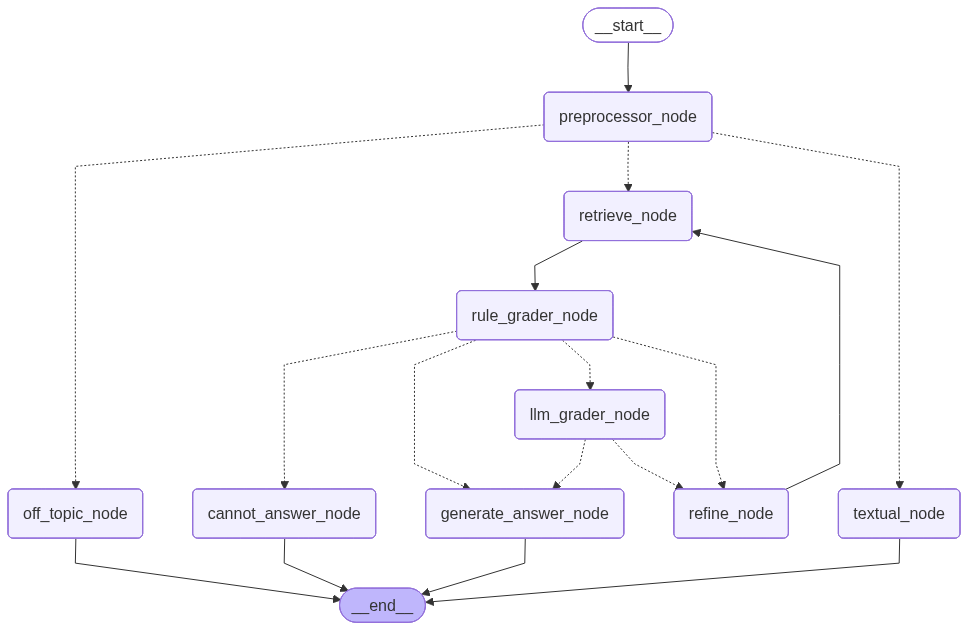

In [78]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [79]:
default_state_template = {
    "last_query": None,
    "last_results": [],
    "last_answer": None,
    "current_book": None,
    "current_part": None,
    "current_chapter": None,
    "current_article": None,
    "filter_type": "",
    "k": 5,
    "books_in_scope": [],
    "query_history": [],
    "retrieval_history": [],
    "retry_count": 0,
    "max_retries": 2,
    "answer_history": [],
    "db_initialized": True,
    "db": db,
    "split_config": {},
    "rewritten_question": None,
    "classification": None,
    "retrieval_confidence": None,
    "refined_query": None,
    "grade": None,
    "llm_pass": None,
    "failure_reason": None,
    "proceedToGenerate": None,
    "retrieval_attempts": 0,
    "final_answer": None
}

In [80]:
TEST_QUESTIONS = [
    # # ===== Textual Node =====
    # "ما هو نص المادة 147 من القانون المدني المصري؟",
    # "أريد نص المادة مائة وسبعة وأربعون في القانون المدني",
    # "ما هي المواد بين 140 و150 المتعلقة بالالتزامات؟",
    # "ما هو نص المادة التي تتعلق بعقد البيع؟",

    # ===== Analytical Node =====
    "ما هي مسؤولية البائع إذا كان المبيع به عيب خفي ولم يذكر في العقد؟",
    "كيف يتم تطبيق قاعدة ‘العقد شريعة المتعاقدين’ على العقود التجارية؟",
    "إذا تعارضت المادة 147 والمادة 150 في موضوع العقد، كيف يتم حل النزاع؟",
    "إذا أخل المستأجر بشروط العقد ولم يدفع الإيجار، ما الحقوق المتاحة للمالك حسب القانون المدني؟",

    # # ===== Off-Topic Node =====
    # "من هو رئيس مصر الحالي؟",
    # "كيف أصنع كوب قهوة؟",
    # "ما هو أسرع حيوان على الأرض؟",

    # ===== Refinement / Edge Cases =====
    "أريد نص المادة التي تتحدث عن الإيجار",
    "ما هي التزامات البائع عندما تكون السلعة فيها خلل",
    "عقد البيع عند الغش",
    "ما هو النص القانوني لعقد الوكالة إذا لم يتم تحديد الأتعاب؟",
    "ما حكم القانون المدني في حالة الطلاق بالتراضي بين الطرفين؟"
]

# for q in TEST_QUESTIONS:
#     state = { **default_state_template, "last_query": q }
#     result_state = preprocessor_node(state)
#     print(q)
#     print(result_state["classification"], result_state["rewritten_question"])

In [81]:
for q in TEST_QUESTIONS:
    state = { **default_state_template, "last_query": q }
    final_state = app.invoke(state)
    
    print("السؤال:", q)
    print("الصنف:", final_state.get("classification"))
    print("السؤال المعاد صياغته:", final_state.get("rewritten_question"))
    print("الإجابة النهائية:", final_state.get("final_answer"))
    print("-" * 60)

السؤال: ما هي مسؤولية البائع إذا كان المبيع به عيب خفي ولم يذكر في العقد؟
الصنف: analytical
السؤال المعاد صياغته: ما هي مسؤولية البائع في حالة وجود عيب خفي في المبيع ولم يذكر ذلك في عقد البيع؟
الإجابة النهائية: تستند الإجابة على القواعد القانونية المذكورة في المواد 447 و449 من القانون المدني المصري.

بناءً على المادة 447، يضمن البائع العيوب التي تنقص القيمة أو المنفعة ولو لم يعلم بها. وهذا يشمل العيوب الخفية التي لا تظهر على الفور.

كما تنص المادة 449 على وجوب إخطار البائع بالعيب خلال مدة معقولة، وإذا كان العيب خفيًا، وجب الإخطار فور ظهوره. 

لذا، في حالة وجود عيب خفي في المبيع ولم يذكر في العقد، يتحمل البائع المسؤولية عن هذا العيب وفقًا للمادة 447 (المادة 447 مدني). 

ومن ثم، يتعين على المشتري إخطار البائع بالعيب الخفي فور ظهوره، كما هو منصوص عليه في المادة 449 (المادة 449 مدني).
------------------------------------------------------------
السؤال: كيف يتم تطبيق قاعدة ‘العقد شريعة المتعاقدين’ على العقود التجارية؟
الصنف: analytical
السؤال المعاد صياغته: كيف يتم تطبيق قاعدة ‘العقد شريعة 